In [1]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta
import random
import tensorflow as tf
import numpy as np
import os

2024-12-05 14:08:59.915976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def make_result_reproducible(seed_value):

    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    # import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    # import random
    random.seed(seed_value)

    # For numpy
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    # import tensorflow as tf
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)



def assign_time_bin(df, aggregation_period):
    start_date = df['occ_date'].min().floor('D')  # Dataset's start date
    end_date = df['occ_date'].max().ceil('D') + timedelta(aggregation_period) # Dataset's end date
    print(end_date)
    time_bins = pd.date_range(start=start_date, end=end_date, freq=f'{aggregation_period}D')

    # Bin the timestamps
    df['time_bin'] = pd.cut(
        df['occ_date'],
        bins=time_bins,
        labels=time_bins[:-1],  # Label bins by their start date
        right=False
    )
    df['time_bin'] = df['time_bin'].astype('datetime64[ns]')

    print(df['time_bin'].dtype)
    return df

def prepare_data(crime_df, grid_df, aggregation_period):
    relevant_columns = ['occ_date', 'x_coordinate', 'y_coordinate']
    crime_df = crime_df[relevant_columns]

    crime_df = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df.x_coordinate, crime_df.y_coordinate))
    crime_df.set_crs('EPSG:2913', inplace=True)

    grid_crime_df = gpd.sjoin(crime_df, grid_df, how='left', predicate='within')
    grid_crime_df.dropna(inplace=True) # drop those crimes that don't fall within any grids inside the city boundry

    grid_crime_df.drop('index_right', axis=1, inplace=True)

    grid_crime_df['occ_date'] = pd.to_datetime(grid_crime_df['occ_date'])  # Ensure time is datetime
    grid_crime_df['hotspot'] = grid_crime_df['hotspot'].astype('int64')  
    grid_crime_df['unique_id'] = grid_crime_df['unique_id'].astype('int64') 
    grid_crime_df['x_index'] = grid_crime_df['x_index'].astype('int64') 
    grid_crime_df['y_index'] = grid_crime_df['y_index'].astype('int64') 

    # Aggregate crime counts over 14 days period
    # grid_crime_df['time_bin'] = grid_crime_df['occ_date'].dt.floor(f'{aggregation_period}D') # doesn't allow for custom bins
    grid_crime_df = assign_time_bin(grid_crime_df, aggregation_period)
    grid_crime_df['day_of_week'] = grid_crime_df['occ_date'].dt.dayofweek

    crime_counts_df = grid_crime_df.groupby(['unique_id', 'x_index', 'y_index', 'time_bin']).size().reset_index(name='crime_count')

    return crime_counts_df

def fill_in_hotspots(crime_counts_df,  hotspot_cells, threshold):
    
    # hotspot_cells = crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= 5)})

    # hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index

    potential_hotspots_crime_counts_df = crime_counts_df[crime_counts_df['unique_id'].isin(hotspot_cells)]
    potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
    potential_hotspots_crime_counts_df.loc[ potential_hotspots_crime_counts_df['crime_count'] >= threshold , 'hotspot'] = 1

    return potential_hotspots_crime_counts_df

def create_sequences(df, seq_length):
    sequences = []
    for cell_id in df['unique_id'].unique():
        cell_data = df[df['unique_id'] == cell_id].sort_values('time_bin')
        for i in range(len(cell_data) - seq_length ):
            sequence = cell_data.iloc[i: i + seq_length + 1]
            sequences.append(sequence)
    return sequences



def calculate_neighbourhood_crime_counts(data, radius=10):
  
    # Ensure data is sorted for efficient processing
    data = data.sort_values(by="time_bin")

    # Prepare results
    results = []

    # Process each time_bin
    for time_bin, group in data.groupby("time_bin"):
        group_results = []
        
        # Convert group to a dictionary for efficient lookup
        crime_lookup = {(row.x_index, row.y_index): row.crime_count for row in group.itertuples()}
        
        # Iterate through each cell
        for _, row in group.iterrows():
            x, y = row["x_index"], row["y_index"]
            
            # Neighborhood bounds
            x_min, x_max = x - radius, x + radius
            y_min, y_max = y - radius, y + radius
            
            # Calculate total crimes in the neighborhood
            total_neighborhood_crime = sum(
                crime_lookup.get((i, j), 0)
                for i in range(x_min, x_max + 1)
                for j in range(y_min, y_max + 1)
            )
            
            # Append result for this cell
            group_results.append({
                "unique_id": row["unique_id"],
                "time_bin": row["time_bin"],
                "neighbourhood_crime_count": total_neighborhood_crime,
            })
        
        # Extend results
        results.extend(group_results)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Merge results back to the original data
    data = data.merge(results_df, on=["unique_id", "time_bin"])
    
    return data


def calculate_neighbourhood_crime_counts_individually(data, radius=1):
    """
    Efficiently calculates neighborhood crime counts for a given radius.
    """
    # Ensure data is sorted
    data = data.sort_values(by=["time_bin", "x_index", "y_index"])

    # Prepare results
    results = []

    # Process each time_bin
    for time_bin, group in data.groupby("time_bin"):
        # Pivot to create a 2D grid of crime counts
        grid = group.pivot_table(index="y_index", columns="x_index", values="crime_count", fill_value=0)

        # Convert to NumPy array for efficient processing
        grid_array = grid.to_numpy()

        # Track the mapping of grid indices to the original data
        grid_mapping = {(x, y): idx for idx, (x, y) in enumerate(zip(group["x_index"], group["y_index"]))}

        # Prepare array to store neighbor counts
        neighbor_counts = np.zeros((len(group), (2 * radius + 1) ** 2 - 1))

        # Add padding around the grid to handle edge cells
        padded_grid = np.pad(grid_array, pad_width=radius, mode="constant", constant_values=0)

        # Calculate neighbor counts using slicing
        neighbor_index = 0
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                if dx == 0 and dy == 0:
                    continue  # Skip the center cell
                neighbor_slice = padded_grid[
                    radius + dy : radius + dy + grid_array.shape[0],
                    radius + dx : radius + dx + grid_array.shape[1],
                ]

                # Map neighbor_slice to the corresponding rows in the group
                for idx, (x, y) in enumerate(zip(group["x_index"], group["y_index"])):
                    if (x, y) in grid_mapping:
                        neighbor_counts[idx, neighbor_index] = neighbor_slice[
                            grid.index.get_loc(y), grid.columns.get_loc(x)
                        ]
                neighbor_index += 1

        # Create DataFrame for neighbors
        neighbor_columns = [
            f"neighbor_{dy+radius+1}_{dx+radius+1}"
            for dx in range(-radius, radius + 1)
            for dy in range(-radius, radius + 1)
            if not (dx == 0 and dy == 0)
        ]
        neighbor_df = pd.DataFrame(
            neighbor_counts,
            columns=neighbor_columns,
            index=group.index,
        )

        # Combine with the group
        group_with_neighbors = pd.concat([group.reset_index(), neighbor_df.reset_index(drop=True)], axis=1)

        # Append results
        results.append(group_with_neighbors)

    # Combine all results
    results_df = pd.concat(results, ignore_index=True)

    return results_df.drop('index', axis=1)


# def calculate_neighbourhood_crime_counts_individually(data, radius=1):
#     """
#     Not so efficient. Overloads memory and swap
#     """

#     # Ensure data is sorted for efficient processing
#     data = data.sort_values(by="time_bin")

#     # Prepare results
#     results = []

#     # Process each time_bin
#     for time_bin, group in data.groupby("time_bin"):
#         group_results = []
        
#         # Convert group to a dictionary for efficient lookup
#         crime_lookup = {(row.x_index, row.y_index): row.crime_count for row in group.itertuples()}
        
#         # Iterate through each cell
#         for _, row in group.iterrows():
#             x, y = row["x_index"], row["y_index"]
            
#             neighbors = {}
#             # Calculate total crimes in the neighborhood
#             for dx in range(-radius, radius + 1):  # Range: -radius to +radius
#                 for dy in range(-radius, radius + 1): 
#                     if dx == 0 and dy == 0: #This is the center cell, its value is allready in the crime_count column
#                         continue

#                     neighbor_x = x + dx
#                     neighbor_y = y + dy

#                     crime_count = crime_lookup.get((neighbor_x, neighbor_y), 0)
                    
#                     neighbors[f'neighbor_{dx+radius+1}_{dy+radius+1}'] = crime_count


#             # total_neighborhood_crime = sum(
#             #     crime_lookup.get((i, j), 0)
#             #     for i in range(x_min, x_max + 1)
#             #     for j in range(y_min, y_max + 1)
#             # )
            
#             # Append result for this cell
#             group_results.append({
#                 "unique_id": row["unique_id"],
#                 "time_bin": row["time_bin"],
#                 **neighbors
#             })
        
#         # Extend results
#         results.extend(group_results)

#     # Convert results to a DataFrame
#     results_df = pd.DataFrame(results)
    
#     # Merge results back to the original data
#     data = data.merge(results_df, on=["unique_id", "time_bin"])
    
#     return data



In [3]:

current_dir = os.getcwd()
train_base_dir = os.path.join(current_dir, "Data", "train")
test_base_dir = os.path.join(current_dir, "Data", "test")
cell_size = 600
aggregation_period = 14 # In days
seed_value = 1
make_result_reproducible(seed_value)

train_crime_df = pd.read_csv(os.path.join(train_base_dir,'combined_train_data.csv'))
test_crime_df = pd.read_csv(os.path.join(test_base_dir,'test_data.csv'))

grid_df = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

train_crime_counts_df = prepare_data(train_crime_df, grid_df, aggregation_period)
test_crime_counts_df = prepare_data(test_crime_df, grid_df, aggregation_period)

combined_crime_counts_df = pd.concat([train_crime_counts_df, test_crime_counts_df])

threshold = train_crime_counts_df.crime_count.quantile(0.98)
print(threshold)
hotspot_cells = train_crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= threshold)})

hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index


train_hotspots_crime_counts_df = fill_in_hotspots(train_crime_counts_df, hotspot_cells, threshold)
test_hotspots_crime_counts_df = fill_in_hotspots(test_crime_counts_df, hotspot_cells, threshold)


sequence_length = 26 # looking over whole year data to capture seasonal trend


2017-03-14 00:00:00
datetime64[ns]
2017-06-14 00:00:00
datetime64[ns]
5.0


/tmp/ipykernel_6865/2113954314.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
/tmp/ipykernel_6865/2113954314.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0


In [8]:
# run only once
last_time_bin = train_hotspots_crime_counts_df.time_bin.max()
start_time_bin_test_data_dependends_upon = last_time_bin - timedelta(aggregation_period*(sequence_length-1))
historical_data_for_test_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.time_bin >= start_time_bin_test_data_dependends_upon ]
test_hotspots_crime_counts_df = pd.concat([historical_data_for_test_df, test_hotspots_crime_counts_df])

#Ensuring all the same cells in both train and test data
# np.all(hotspot_cells == np.sort(test_hotspots_crime_counts_df.unique_id.unique()) )

test_hotspots_crime_counts_df.unique_id.unique().size
test_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,hotspot
839,1290,33,96,2016-03-10,1,0
840,1290,33,96,2016-03-24,2,0
841,1290,33,96,2016-04-07,1,0
842,1290,33,96,2016-04-21,2,0
843,1290,33,96,2016-05-05,2,0
...,...,...,...,...,...,...
6353,11781,148,34,2017-05-24,1,0
6369,11822,149,34,2017-03-29,1,0
6370,11822,149,34,2017-04-12,2,0
6371,11822,149,34,2017-04-26,3,0


In [9]:
train_time_bins = pd.date_range(train_crime_counts_df.time_bin.min(), train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_history = pd.date_range(start_time_bin_test_data_dependends_upon, train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins_current = pd.date_range(test_crime_counts_df.time_bin.min(), test_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins = test_time_bins_history.append(test_time_bins_current)

In [10]:

all_train_cells = train_crime_counts_df.groupby(['unique_id', 'x_index', 'y_index']).size().reset_index()
all_test_cells = test_crime_counts_df.groupby(['unique_id', 'x_index', 'y_index']).size().reset_index()

# all_train_cells_dict  = train_crime_counts_df.set_index(['unique_id', 'x_index', 'y_index']).T.to_dict() # just a bit faster
# train_time_bins_df = pd.DataFrame([(unique_id, x_index, y_index, time_bin) for unique_id, x_index, y_index in all_train_cells_dict for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
# train_time_bins_df
train_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for _, row in all_train_cells.iterrows() for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
test_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for _, row in all_train_cells.iterrows() for time_bin in test_time_bins.sort_values()],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])

# # train_time_bins_df = pd.DataFrame([(row['unique_id'], row['x_index'], row['y_index'], time_bin) for index, row in train_crime_counts_df.iterrows() for time_bin in train_time_bins],columns=['unique_id', 'x_index', 'y_index', 'time_bin'])
# # test_time_bins_df = pd.DataFrame([(unique_id, time_bin) for unique_id in all_test_cells for time_bin in test_time_bins],columns=['unique_id', 'time_bin'])

# train_crime_counts_df_with_all_time_bins = train_time_bins_df.merge(train_crime_counts_df, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
# # test_crime_counts_df_with_all_time_bins = test_time_bins_df.merge(test_crime_counts_df, on=[ 'unique_id'], how='left').fillna(0)

# # # test_crime_counts_df_with_all_time_bins = 


In [11]:
test_crime_counts_df_with_history = combined_crime_counts_df[combined_crime_counts_df['time_bin']>=start_time_bin_test_data_dependends_upon]
train_crime_counts_df_with_all_time_bins = train_time_bins_df.merge(train_crime_counts_df, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
test_crime_counts_df_with_all_time_bins = test_time_bins_df.merge(test_crime_counts_df_with_history, on=['unique_id', 'x_index', 'y_index', 'time_bin'], how='left').fillna(0)
train_crime_counts_df_with_all_time_bins['crime_count'].max()
test_crime_counts_df_with_all_time_bins['crime_count'].max()

19.0

In [ ]:

# train_hotspots_crime_counts_df["neighbourhood_crime_counts"] = train_crime_counts_df_with_all_time_bins.apply(
#     calculate_neighbourhood_crime_count, axis=1, args=(train_crime_counts_df_with_all_time_bins, 1 )
# )

radius = 10 # for 21x21 cells

train_hotspots_crime_counts_df = calculate_neighbourhood_crime_counts_individually(train_crime_counts_df_with_all_time_bins, radius=radius)
test_hotspots_crime_counts_df = calculate_neighbourhood_crime_counts_individually(test_crime_counts_df_with_all_time_bins, radius=radius)
# x = calculate_neighbourhood_crime_counts(train_hotspots_crime_counts_df, radius=1)

# test_hotspots_crime_counts_df["neighbourhood_crime_counts"] = test_crime_counts_df_with_all_time_bins.apply(
#     calculate_neighbourhood_crime_count, axis=1, args=(test_crime_counts_df_with_all_time_bins, 10 )
# )



In [56]:
# test_hotspots_crime_counts_df.drop('index', axis=1)
train_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbor_1_1,neighbor_2_1,neighbor_3_1,neighbor_4_1,neighbor_5_1,...,neighbor_12_21,neighbor_13_21,neighbor_14_21,neighbor_15_21,neighbor_16_21,neighbor_17_21,neighbor_18_21,neighbor_19_21,neighbor_20_21,neighbor_21_21
0,26,2,99,2012-03-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32,2,105,2012-03-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4,102,2012-03-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,57,5,100,2012-03-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58,5,101,2012-03-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913458,11925,153,69,2017-02-23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913459,11926,153,70,2017-02-23,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913460,11929,153,73,2017-02-23,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
913461,11949,154,73,2017-02-23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
train_hotspots_crime_counts_df.loc[:, 'hotspot'] = 0
train_hotspots_crime_counts_df.loc[train_hotspots_crime_counts_df.crime_count >= threshold , 'hotspot'] = 1
test_hotspots_crime_counts_df.loc[:, 'hotspot'] = 0
test_hotspots_crime_counts_df.loc[test_hotspots_crime_counts_df.crime_count >= threshold , 'hotspot'] = 1
train_hotspots_crime_counts_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.unique_id.isin(hotspot_cells)]
test_hotspots_crime_counts_df = test_hotspots_crime_counts_df[test_hotspots_crime_counts_df.unique_id.isin(hotspot_cells)]

In [58]:
train_hotspots_crime_counts_df
train_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbor_1_1,neighbor_2_1,neighbor_3_1,neighbor_4_1,neighbor_5_1,...,neighbor_13_21,neighbor_14_21,neighbor_15_21,neighbor_16_21,neighbor_17_21,neighbor_18_21,neighbor_19_21,neighbor_20_21,neighbor_21_21,hotspot
178,1290,33,96,2012-03-01,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
180,1292,33,98,2012-03-01,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
200,1370,34,97,2012-03-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
201,1371,34,98,2012-03-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
226,1448,35,101,2012-03-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913372,11686,146,34,2017-02-23,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
913379,11693,146,41,2017-02-23,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
913395,11735,147,33,2017-02-23,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
913418,11781,148,34,2017-02-23,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
hotspot_cells.size
train_hotspots_crime_counts_df.to_csv(os.path.join(current_dir, 'Data', 'intermediates',str(cell_size),  f'train_hotspots_crime_counts_df_{threshold}_{sequence_length}_{radius}.csv'))
test_hotspots_crime_counts_df.to_csv(os.path.join(current_dir, 'Data', 'intermediates', str(cell_size), f'test_hotspots_crime_counts_df_{threshold}_{sequence_length}_{radius}.csv'))


In [ ]:
# radius = 10
train_hotspots_crime_counts_df = pd.read_csv(os.path.join(current_dir, 'Data', 'intermediates',str(cell_size),  f'train_hotspots_crime_counts_df_{threshold}_{sequence_length}_{radius}.csv'), index_col = 0)
test_hotspots_crime_counts_df = pd.read_csv(os.path.join(current_dir, 'Data', 'intermediates', str(cell_size), f'test_hotspots_crime_counts_df_{threshold}_{sequence_length}_{radius}.csv'), index_col = 0)


In [ ]:

train_hotspots_crime_counts_df = train_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])
test_hotspots_crime_counts_df = test_hotspots_crime_counts_df.sort_values(['unique_id', 'time_bin'])
test_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbor_1_1,neighbor_2_1,neighbor_3_1,neighbor_4_1,neighbor_5_1,...,neighbor_13_21,neighbor_14_21,neighbor_15_21,neighbor_16_21,neighbor_17_21,neighbor_18_21,neighbor_19_21,neighbor_20_21,neighbor_21_21,hotspot
178,1290,33,96,2016-03-10,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
7151,1290,33,96,2016-03-24,2.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
14124,1290,33,96,2016-04-07,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
21097,1290,33,96,2016-04-21,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
28070,1290,33,96,2016-05-05,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202190,11822,149,34,2017-03-29,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
209163,11822,149,34,2017-04-12,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
216136,11822,149,34,2017-04-26,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
223109,11822,149,34,2017-05-10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
train_hotspots_crime_counts_df['hotspot'] = train_hotspots_crime_counts_df['hotspot'].astype(int)
test_hotspots_crime_counts_df['hotspot'] = test_hotspots_crime_counts_df['hotspot'].astype(int)

In [8]:
train_hotspots_crime_counts_df
test_hotspots_crime_counts_df

,unique_id,x_index,y_index,time_bin,crime_count,neighbor_1_1,neighbor_2_1,neighbor_3_1,neighbor_4_1,neighbor_5_1,...,neighbor_13_21,neighbor_14_21,neighbor_15_21,neighbor_16_21,neighbor_17_21,neighbor_18_21,neighbor_19_21,neighbor_20_21,neighbor_21_21,hotspot
178,1290,33,96,2016-03-10,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
7151,1290,33,96,2016-03-24,2.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
14124,1290,33,96,2016-04-07,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
21097,1290,33,96,2016-04-21,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
28070,1290,33,96,2016-05-05,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202190,11822,149,34,2017-03-29,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
209163,11822,149,34,2017-04-12,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
216136,11822,149,34,2017-04-26,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
223109,11822,149,34,2017-05-10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
training_sequences = create_sequences(train_hotspots_crime_counts_df, seq_length=sequence_length)


In [21]:
# training_sequences[1]

In [10]:
testing_sequences = create_sequences(test_hotspots_crime_counts_df, seq_length=sequence_length)

In [68]:
# testing_sequences[0]

In [47]:
from sklearn.utils import resample

positive_data = []
negative_data = []
for sequence in training_sequences:
    if sequence['hotspot'].iloc[-1] == 1:
        positive_data.append(sequence)
    else:
        negative_data.append(sequence)

print(len(positive_data))
negative_data = resample(negative_data, replace=False,  n_samples=len(positive_data), random_state=1) 

# Combine positive and negative data
balanced_data = positive_data + negative_data

from sklearn.model_selection import train_test_split


# Split into training and remaining sets
train_data, val_data = train_test_split(balanced_data, test_size=0.1, random_state=seed_value)

test_data = testing_sequences
# # Split the remaining set into validation and test sets
# val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=1)

2248


In [19]:
list(train_data[0].columns[4:-1])

['crime_count',
 'neighbor_1_1',
 'neighbor_2_1',
 'neighbor_3_1',
 'neighbor_4_1',
 'neighbor_5_1',
 'neighbor_6_1',
 'neighbor_7_1',
 'neighbor_8_1',
 'neighbor_9_1',
 'neighbor_10_1',
 'neighbor_11_1',
 'neighbor_12_1',
 'neighbor_13_1',
 'neighbor_14_1',
 'neighbor_15_1',
 'neighbor_16_1',
 'neighbor_17_1',
 'neighbor_18_1',
 'neighbor_19_1',
 'neighbor_20_1',
 'neighbor_21_1',
 'neighbor_1_2',
 'neighbor_2_2',
 'neighbor_3_2',
 'neighbor_4_2',
 'neighbor_5_2',
 'neighbor_6_2',
 'neighbor_7_2',
 'neighbor_8_2',
 'neighbor_9_2',
 'neighbor_10_2',
 'neighbor_11_2',
 'neighbor_12_2',
 'neighbor_13_2',
 'neighbor_14_2',
 'neighbor_15_2',
 'neighbor_16_2',
 'neighbor_17_2',
 'neighbor_18_2',
 'neighbor_19_2',
 'neighbor_20_2',
 'neighbor_21_2',
 'neighbor_1_3',
 'neighbor_2_3',
 'neighbor_3_3',
 'neighbor_4_3',
 'neighbor_5_3',
 'neighbor_6_3',
 'neighbor_7_3',
 'neighbor_8_3',
 'neighbor_9_3',
 'neighbor_10_3',
 'neighbor_11_3',
 'neighbor_12_3',
 'neighbor_13_3',
 'neighbor_14_3',
 'n

In [ ]:

features = list(train_data[0].columns[4:-1]) # all columns except 'unique_id', 'x_index', 'y_index', 'time_bin' and 'hotspot'


def prepare_trainable_data(samples):
    X = []
    y = []
    for seq in samples:
        X_seq = seq[features].values  # Select features for X
        X.append(X_seq[:-1])  # Exclude the last time step from X
        y.append(seq['hotspot'].iloc[-1])  # Use the last time step's 'hotspot' value as y
    # return X, y
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = prepare_trainable_data(train_data)

# Prepare validation data
X_val, y_val = prepare_trainable_data(val_data)

# Prepare test data
X_test, y_test = prepare_trainable_data(test_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape



((4046, 26, 441), (2457, 26, 441), (4046,), (2457,))

In [21]:
# X_train.shape, X_test.shape
# np.save('a.npy',X_train,)

In [65]:
make_result_reproducible(seed_value)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=2, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate= 0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 


In [66]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5066 - loss: 0.7042 - val_accuracy: 0.5267 - val_loss: 0.6904
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5249 - loss: 0.6884 - val_accuracy: 0.5822 - val_loss: 0.6708
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5496 - loss: 0.6703 - val_accuracy: 0.6289 - val_loss: 0.6521
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6204 - loss: 0.6456 - val_accuracy: 0.6711 - val_loss: 0.6363
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6512 - loss: 0.6240 - val_accuracy: 0.7022 - val_loss: 0.6205
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6665 - loss: 0.6085 - val_accuracy: 0.7044 - val_loss: 0.6073
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6775 - loss: 0.5980 - val_accuracy: 0.7222 - val_loss: 0.5936
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6921 - loss: 0.5845 - val_accuracy: 0.7244 - v

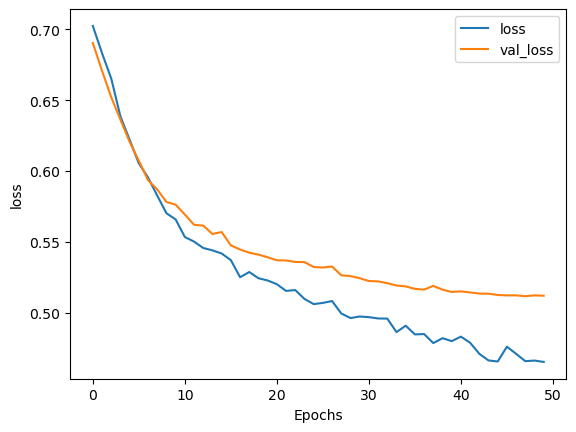

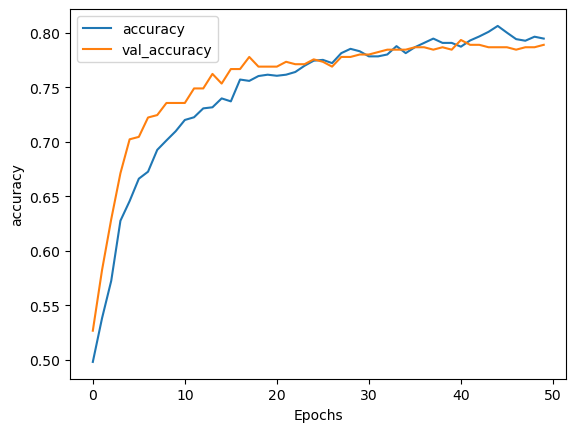

In [67]:
import matplotlib.pyplot as plt
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'loss')
plot_history(history, 'accuracy')
# plot_history(history, 'precision')
# plot_history(history, 'recall')


In [32]:
X_test
test = np.load('a.npy')
np.all(X_test == test)

False

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the val data
# _, accuracy = model.evaluate(X_test, y_test)
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
# print(metrics)
# Make predictions on the val data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.9).astype(int)  # Convert probabilities to binary predictions   


# Calculate additional metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test,  y_pred_binary)

print('Precision: %.2f' % (precision*100))
print('Recall: %.2f' % (recall*100))
print('F1-score: %.2f' % (f1*100))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8592 - loss: 0.4420
Accuracy: 86.98
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Precision: 70.00
Recall: 4.49
F1-score: 8.43


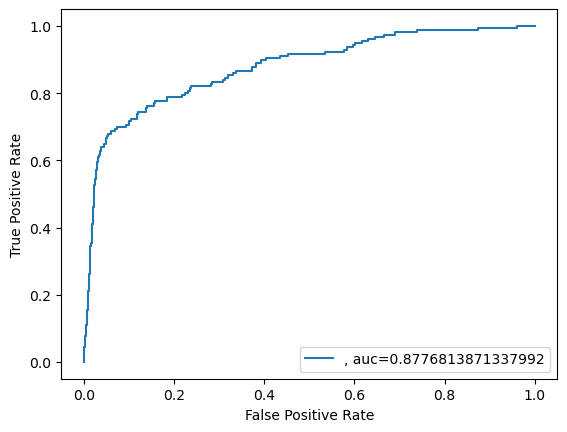

In [69]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr,tpr,label=", auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
# test_data.shape
# X_test.shape, len(test_data)
# import datetime
# x = pd.concat(test_data)
# y = []
# for i in range(1,len(hotspot_cells)):
#     y.append(x['hotspot'].iloc[24*i])

# # test_data[6]
# x[x.time_bin.dt.date == datetime.date(2017,3,1)].drop_duplicates()

In [117]:
import datetime
crime_hotspots = test_hotspots_crime_counts_df[test_hotspots_crime_counts_df.time_bin.dt.date >= datetime.date(2017, 3, 1) ]

crime_hotspots.loc[:,'predicted'] = y_pred_binary
# crime_hotspots.to_csv('forecasted_result.csv')


/tmp/ipykernel_380883/852830955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_hotspots.loc[:,'predicted'] = y_pred_binary


In [118]:
cell_size = 600
grid = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

In [119]:
test_time_step_starting_dates = test_time_bins[-7:]
crime_hotspots_1st_week = crime_hotspots[crime_hotspots.time_bin.dt.date == test_time_step_starting_dates[0].date() ]

predicted_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].unique_id)
hotspot_grid_ids = np.array(crime_hotspots_1st_week[crime_hotspots_1st_week['hotspot'] == 1].unique_id)

total_crimes_in_predicted_hotspots = crime_hotspots_1st_week[crime_hotspots_1st_week['predicted'] == 1].crime_count.sum()
total_crimes = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date == test_time_step_starting_dates[0].date()].crime_count.sum()

predicted_hotspots_area = grid[grid.unique_id.isin(predicted_grid_ids)].area.sum()
total_area = grid.area.sum()
# # # x

In [120]:

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)


pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
print(f"PAI = {pai}")
# pai


64.0
1381
2520000.0
4117743414.8055296
PAI = 75.72600328366661


In [122]:
import math
test_crime_count_list = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date == test_time_step_starting_dates[0].date()].crime_count
desc_sorted = -np.sort(-np.array(test_crime_count_list))
number_of_cells =  math.ceil(predicted_hotspots_area/ (cell_size**2)) # Rough estimation that each cell is of size cell_size_sq
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted[:number_of_cells].sum()

pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
print(f"PEI: {pei}")

# grid['pre']
    
# # y_test
# test_crime_counts_df.crime_count.max()

PEI: 0.8648648648648649


In [123]:
len(predicted_grid_ids), len(hotspot_grid_ids), len(np.intersect1d(predicted_grid_ids, hotspot_grid_ids))

(7, 25, 7)

In [ ]:
grid.loc[grid.unique_id.isin(predicted_grid_ids), 'hotspot'] = 1
grid.loc[grid.unique_id.isin(hotspot_grid_ids), 'hotspot'] = 2
grid.loc[grid.unique_id.isin(np.intersect1d(predicted_grid_ids, hotspot_grid_ids)), 'hotspot'] = 3
grid.to_file(f"visualizations/{cell_size}/crime-forecast-grid-mar-01-mar-14.shp")


### For 3 month period

In [124]:


all_predicted_hotspot_cell_ids =  crime_hotspots[crime_hotspots.predicted == 1].unique_id.unique()
all_hotspot_cell_ids =  crime_hotspots[crime_hotspots.hotspot == 1].unique_id.unique()


total_crimes_in_predicted_hotspots = crime_hotspots[crime_hotspots['predicted'] == 1].crime_count.sum()
total_crimes = test_crime_counts_df[test_crime_counts_df.time_bin.dt.date >= test_time_step_starting_dates[0].date()].crime_count.sum()

predicted_hotspots_area = grid[grid.unique_id.isin(all_predicted_hotspot_cell_ids)].area.sum()
total_area = grid.area.sum()

np.intersect1d(all_hotspot_cell_ids, all_predicted_hotspot_cell_ids)

array([ 4460,  4576,  5040,  5042,  5043,  5044,  5155,  5156,  5157,
        5158,  5270,  5271, 11441, 11517])

In [125]:

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)

pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
print(f"PAI = {pai}")


590.0
9553
5365351.739489673
4117743414.8055296
PAI = 47.399451564054985


In [126]:


desc_sorted_test_crime_count_list = test_crime_counts_df.groupby('unique_id').agg({'crime_count': lambda x: sum(x)}).crime_count.sort_values(ascending=False)
number_of_cells =  math.ceil(predicted_hotspots_area/ (cell_size**2)) # Rough estimation that each cell is of size cell_size_sq
# print(number_of_cells)
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted_test_crime_count_list[:number_of_cells].sum()
# print(desc_sorted)
pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
print(f"PEI: {pei}")
print(total_crimes_in_predicted_hotspots)
print(maximum_obtainable_crimes_for_the_forecasted_area)



PEI: 0.7612903225806451
590.0
775


In [ ]:
grid.loc[grid.unique_id.isin(all_predicted_hotspot_cell_ids), 'hotspot'] = 1
grid.loc[grid.unique_id.isin(all_hotspot_cell_ids), 'hotspot'] = 2
grid.loc[grid.unique_id.isin(np.intersect1d(all_predicted_hotspot_cell_ids, all_hotspot_cell_ids)), 'hotspot'] = 3
grid.to_file(f"visualizations/{cell_size}/crime-forecast-grid-mar-01-may-31.shp")


## OLD Extra

In [ ]:
# ## Grid Search

# # import os
# # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# import numpy as np
# from sklearn.model_selection import GridSearchCV
# # from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from scikeras.wrappers import KerasClassifier


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam


# # Define the LSTM model
# def create_model(units_layer1=50,units_layer2=50, learning_rate=0.001):
#     model = Sequential()
#     model.add(LSTM(units=units_layer1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(LSTM(units=units_layer2))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
#     return model

# # Create a KerasClassifier
# model = KerasClassifier(build_fn=create_model, metrics=['accuracy'],verbose=0)

# # Define the hyperparameter grid
# # param_grid = {
# #     'model__units': [20, 50, 80],
# #     'model__learning_rate': [0.01, 0.001, 0.0001],
# #     'batch_size': [16, 32, 64],
# #     'epochs': [20, 30, 40]
# # }

# param_grid = {
#     'model__units': [20,50,80],
#     'model__learning_rate': [0.001, 0.0001],
#     'batch_size': [32, 64],
#     'epochs': [20, 50]
# }
# param_grid = {
#     'model__units_layer1': [50,100],
#     'model__units_layer2': [25,50],
#     'model__learning_rate': [0.001, 0.0001],
#     'batch_size': [32],
#     'epochs': [50]
# }

# model = KerasClassifier(model=create_model, optimizer='adam', verbose=0)

# # Fit and predict
# # model.fit(X_train, y_train)
# # predictions = model.predict(X_test)


# # # Create a GridSearchCV object
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, error_score='raise')  # 3-fold cross-validation

# # Fit the grid search to the data
# grid_result = grid.fit(X_train, y_train)

# # Print the best hyperparameters
# print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")